Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os.path as op

import matplotlib.pyplot as plt
import seaborn as sns
# import spacy
# nlp = spacy.load('en')

Load Data

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'gofundme_projects.csv'))

In [4]:
labeled = labeled.loc[labeled['project_id'].isin(all_projects['id'])]

# Simpson's Index of Diversity

In [ ]:
kw = np.array([1,1,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

kw = np.array([1,0,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

In [ ]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        # battle productivity
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        #     sum n(n - 1) 
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            battle_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            battle_div = 0.0
        
        # journey productivity
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            journey_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            journey_div = 0.0
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

Top projects by productivity, after looking at the text of these projects, the measure seems like an accurate representation of diversity in metaphor instantiation.

In [ ]:
productivities.nlargest(10, 'battle_prod')

An example project:

In [ ]:
all_projects.loc[all_projects['id'] == 1665364667, :]

In [ ]:
labeled.loc[labeled['project_id'] == 1665364667]

Create a copy (so as to not affect the original) and merge

In [ ]:
all_projects_c = all_projects.copy(deep=True)

In [ ]:
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

It looks like our measures of diversity are highly correlated with salience:

In [ ]:
np.corrcoef(all_projects_c[['battle_prod', 'journey_prod', 'battle_salience', 'journey_salience']], rowvar=False)

# Custom Productivity

Let $C$ be the set of keyword counts over all projects. Each keyword appears $C_i \gt 0$ times, such that $i=1, 2, ..., N$ where $N$ is the number of unique keywords in the corpus.

Let $W$ be the set of keyword counts for a given project, where $W_i \geq 0$ for $i=1, 2, ..., N$. $C_i$ and $W_i$ represent the same keyword.

Productivity for each keyword family of a given project is:
$$
P_{\text{family}} = \sum_{i=1}^N W_i \times \big(\frac{\sum_{k=1}^N C_k}{C_i}\big)^r
$$
where $r$ is some proportionality constant.

In the following work, $r=0.4$ because this results in the least frequent word, *enemy*, becoming the "equivalent" (in terms of how creative we perceive its usage) to about 8 usages of the most frequent word, *fight*. This number is partially arbitrary and can be changed as seen fit. The frequency proportion (the value raised to $r$) is divided by the minimum of the set of frequency proportions, thereby forcing the most frequent word to have a frequency proportion of 1.0.



In [15]:
battle_vc = labeled.dropna().loc[(labeled['type'] == 'battle') & (labeled['metaphorical'] == True), 'keyword'].value_counts()
journey_vc = labeled.dropna().loc[(labeled['type'] == 'journey')& (labeled['metaphorical'] == True), 'keyword'].value_counts()

# print(battle_vc)

r = 0.5

battle_freq_map = (sum(battle_vc) / battle_vc) ** r
battle_freq_map = dict(battle_freq_map / min(battle_freq_map))

journey_freq_map = (sum(journey_vc) / journey_vc) ** r
journey_freq_map = dict(journey_freq_map / min(journey_freq_map))

print(battle_freq_map)
print(journey_freq_map)

{'fight': 1.0, 'battle': 1.2890154787469803, 'fighting': 1.5667614302472295, 'beat': 1.9168186008037111, 'battling': 2.4199258523982503, 'fought': 3.5281847218780915, 'win': 3.7615247337989635, 'beating': 4.321126143442353, 'fights': 4.393755198661244, 'battled': 5.336197147782304, 'battles': 5.474822756083188, 'defeat': 7.0371684028758885, 'beaten': 8.57227338386626, 'winning': 9.360309002131531, 'war': 9.952058996050493, 'combat': 9.952058996050493, 'beats': 10.949645512166375, 'enemy': 13.778001790293587}
{'journey': 1.0, 'road': 1.344276625556548, 'path': 3.3681514877517675, 'rollercoaster': 6.149375156454094}


In [6]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

c = 0

# group by id
for i, g in labeled.loc[labeled['metaphorical'].fillna(False)].groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts()
    s = [battle_freq_map[k] * kw[k] for k in dict(kw)]
    battle_div = sum(s)

    kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts()
    s = [journey_freq_map[k] * kw[k] for k in dict(kw)]
    journey_div = sum(s)
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

In [7]:
all_projects_c = all_projects.copy(deep=True)
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')
all_projects_c['battle_prod_y'] = all_projects_c['battle_prod_y'].fillna(0)
all_projects_c['journey_prod_y'] = all_projects_c['journey_prod_y'].fillna(0)

## Inverse TF-IDF

In [8]:
j_mask = labeled["type"] == "journey"
b_mask = labeled["type"] == "battle"

In [9]:
j_N = len(set(labeled[j_mask].dropna()["project_id"]))
j_T = len(labeled[j_mask].dropna()["keyword"])
b_N = len(set(labeled[b_mask].dropna()["project_id"]))
b_T = len(labeled[b_mask].dropna()["keyword"])
b_N, b_T, j_N, j_T

(3097, 6943, 1324, 1866)

In [62]:
labeled[b_mask].dropna().groupby("keyword").apply(
    lambda x: 
        (x["project_id"].count(), # number of times keyword found
#          b_T, # total battle keywords
         round(x["project_id"].count() / b_T, 3), # frequency of keyword among battle words
#          b_N, # total number of unique campaigns
#          len(set(x["project_id"])), # number of campaigns the keyword appears in
         round(len(set(x["project_id"])) / b_N, 3), # portion of campaigns the word appears in
#          round(b_N / len(set(x["project_id"])), 2), # average # of campaigns between word appearance
         round(1 / ((x["project_id"].count() / b_T) * np.log(b_N / len(set(x["project_id"])))), 3))
)

keyword
battle       (1413, 0.204, 0.347, 4.64)
battled      (88, 0.013, 0.028, 22.086)
battles      (86, 0.012, 0.027, 22.306)
battling      (422, 0.061, 0.127, 7.98)
beat         (673, 0.097, 0.187, 6.146)
beaten       (33, 0.005, 0.011, 46.325)
beating     (132, 0.019, 0.041, 16.427)
beats        (25, 0.004, 0.007, 56.646)
combat       (40, 0.006, 0.012, 38.965)
defeat       (49, 0.007, 0.015, 34.004)
enemy        (17, 0.002, 0.005, 77.562)
fight       (2347, 0.338, 0.496, 4.222)
fighting     (1008, 0.145, 0.269, 5.25)
fights      (122, 0.018, 0.036, 17.143)
fought      (215, 0.031, 0.065, 11.829)
war           (61, 0.009, 0.016, 27.45)
win          (176, 0.025, 0.05, 13.173)
winning      (36, 0.005, 0.012, 43.294)
dtype: object

In [33]:
itfidf_battle = labeled[b_mask].dropna().groupby("keyword").apply(
    lambda x: 
        1 / (x["project_id"].count() / b_T * np.log(b_N / len(set(x["project_id"]))))
    # inverse    total kw count     total docs      unique   
)
itfidf_journey = labeled[j_mask].dropna().groupby("keyword").apply(
    lambda x: 
        1 / (x["project_id"].count() / j_T * np.log(j_N / len(set(x["project_id"]))))
)

itfidf_battle = (itfidf_battle / min(itfidf_battle)) ** 0.9
itfidf_journey = (itfidf_journey / min(itfidf_journey))

print(itfidf_battle)
print(itfidf_journey)

keyword
battle       1.088517
battled      4.433026
battles      4.472700
battling     1.773272
beat         1.401897
beaten       8.634320
beating      3.396263
beats       10.347807
combat       7.389205
defeat       6.536860
enemy       13.730254
fight        1.000000
fighting     1.216589
fights       3.529182
fought       2.527295
war          5.391228
win          2.784184
winning      8.124178
dtype: float64
keyword
journey          1.000000
path             1.775184
road             1.079024
rollercoaster    5.398056
dtype: float64


In [34]:
itfidf_journey = pd.DataFrame({"kw": itfidf_journey.index, "w": itfidf_journey.values, "method": "itfidf", "family": "journey"})
itfidf_battle = pd.DataFrame({"kw": itfidf_battle.index, "w": itfidf_battle.values, "method": "itfidf", "family": "battle"})
custom_journey = pd.DataFrame({"kw": list(journey_freq_map.keys()), "w": list(journey_freq_map.values()), "method": "custom", "family": "journey"})
custom_battle = pd.DataFrame({"kw": list(battle_freq_map.keys()), "w": list(battle_freq_map.values()), "method": "custom", "family": "battle"})

comb = pd.concat([itfidf_journey,
                itfidf_battle,
                custom_journey,
                custom_battle], axis=0)
comb

,kw,w,method,family
0,journey,1.000000,itfidf,journey
1,path,1.775184,itfidf,journey
2,road,1.079024,itfidf,journey
3,rollercoaster,5.398056,itfidf,journey
0,battle,1.088517,itfidf,battle
1,battled,4.433026,itfidf,battle
2,battles,4.472700,itfidf,battle
3,battling,1.773272,itfidf,battle
4,beat,1.401897,itfidf,battle
5,beaten,8.634320,itfidf,battle


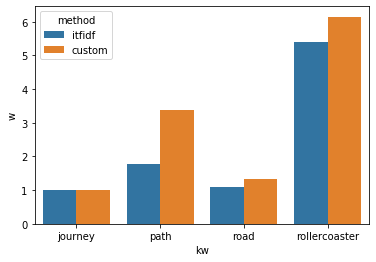

In [36]:
sns.barplot("kw", "w", hue="method", data = comb[comb["family"] == "journey"])

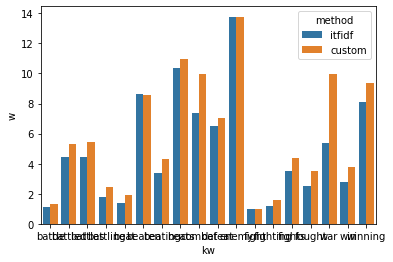

In [40]:
sns.barplot("kw", "w", hue="method", data = comb[comb["family"] == "battle"])